# Twitter Sentiment Analysis

## 1. Business Understanding
### Introduction
In today’s digital world, customers frequently share their opinions and experiences about technology products on social media platforms such as Twitter. For companies like **Apple** and **Google**, these real-time opinions provide valuable insights into how users perceive their products, services, and brand reputation. However, the sheer volume of tweets makes it difficult for businesses to manually analyze and understand overall customer sentiment.

This project addresses the challenge of **automatically analyzing Twitter sentiment** related to Apple and Google products. By building a machine learning model that can classify tweets as *positive, negative, or neutral*, businesses can gain a scalable and data-driven way to monitor public opinion.

### Stakeholders
Several stakeholders can benefit from this project:
- **Marketing Teams**: Track the effectiveness of new product launches, advertisements, and promotions by monitoring changes in sentiment over time.
- **Product Managers**: Identify customer pain points and areas for improvement in specific products or services.
- **Customer Support Teams**: Detect spikes in negative sentiment that may signal product issues or service disruptions requiring immediate response.
- **Executives and Business Strategists**: Use sentiment trends as part of decision-making for competitive positioning against rivals and for forecasting brand perception.

### Conclusion
By developing a sentiment analysis model for Apple and Google-related tweets, stakeholders gain a practical tool for understanding and responding to customer perceptions in real time. This capability helps companies stay competitive in the fast-paced technology industry by enabling **proactive decision-making**, **improved customer engagement**, and **data-driven product development**. Ultimately, the project demonstrates how Natural Language Processing (NLP) can turn unstructured social media data into actionable business intelligence.

## 2. Data Understanding
In this chapter, we explore the dataset to understand its source, structure, and properties.  
Data understanding is critical because it ensures we know what signals exist in the dataset, how reliable they are, and how they align with the business problem.  

Our goals in this chapter are to:
1. Load and preview the dataset.  
2. Check for missing values and duplicates.  
3. Understand dataset size and feature types.  
4. Explore descriptive statistics for text length and categories.  
5. Examine sentiment and product distributions.  
6. Identify limitations that impact modeling.  

By the end of this chapter, we will know what features are useful, what preprocessing steps are needed, and what challenges we must anticipate when modeling.

### Step 1: Load and Preview the Dataset

The first step in data understanding is to load the dataset into our environment and preview its structure.  
This helps us verify the columns, check for unexpected encodings, and see a snapshot of the content.  


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

FILE_PATH = "judge-1377884607_tweet_product_company.csv"

# Robust CSV loader to handle encodings
def load_csv(path):
    try:
        return pd.read_csv(path)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="latin-1")

df = load_csv(FILE_PATH)

# Clean column names for consistency
df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]

# Preview first rows
display(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Shape: (9093, 3)
Columns: ['tweet_text', 'emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']


### Step 2: Inspect Dataset Info and Missing Values

Understanding column data types and missing values is essential.  
- It shows which columns are text, categorical, or numerical.  
- It helps us identify where imputation or cleaning may be needed.  

In [2]:
# Column types and non-null counts
df.info()

# Missing values per column
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

### Step 3: Check for Duplicates

Duplicate records can bias our model by overweighting certain examples.  
We check for duplicates to decide whether to drop or retain them.  


In [3]:
num_dupes = df.duplicated().sum()
print("Duplicate rows:", num_dupes)

Duplicate rows: 22


### Step 4: Rename Columns to Meaningful Names

For clarity, we rename columns into more readable names that align with our analysis:  
- `tweet_text` → tweet content (feature)  
- `emotion_in_tweet_is_directed_at` → product or brand (context feature)  
- `is_there_an_emotion_directed_at_a_brand_or_product` → sentiment label (target)

In [4]:
df = df.rename(columns={
    "tweet_text": "tweet_text",
    "emotion_in_tweet_is_directed_at": "product_or_brand",
    "is_there_an_emotion_directed_at_a_brand_or_product": "sentiment"
})
df.head()

,tweet_text,product_or_brand,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Step 5: Explore Descriptive Statistics of Text

Since tweets are unstructured text, we begin by measuring tweet length.  
- This helps us understand typical tweet size and whether there are unusually short or long tweets.  
- It also informs preprocessing choices, like truncation or padding in NLP models.  

In [5]:
# Robust text-length features that handle NaNs and non-strings

s = df["tweet_text"]  # [Series: one column of the DataFrame]

# Character count: .str.len() returns NaN for missing; we turn that into 0, then to int
df["tweet_len_char"] = s.str.len().fillna(0).astype("int64")  # [NaN: missing value; dtype: data type]

# Word count: split on whitespace, then count tokens; handle NaN the same way
df["tweet_len_word"] = s.str.split().str.len().fillna(0).astype("int64")

# Quick sanity check stats (count/mean/std/min/percentiles/max)
df[["tweet_len_char", "tweet_len_word"]].describe()


,tweet_len_char,tweet_len_word
count,9093.000000,9093.000000
mean,104.950731,17.763444
std,27.208419,4.964105
min,0.000000,0.000000
25%,86.000000,14.000000
50%,109.000000,18.000000
75%,126.000000,21.000000
max,178.000000,33.000000


### Step 6: Analyze Sentiment Distribution

The target variable is sentiment.  
We need to check the distribution to see if it is balanced, because imbalance can bias the model.  


In [6]:
sent_counts = df["sentiment"].value_counts()
sent_percent = (sent_counts / sent_counts.sum() * 100).round(2)

display(pd.DataFrame({"count": sent_counts, "percent": sent_percent}))

,count,percent
sentiment,,
No emotion toward brand or product,5389,59.27
Positive emotion,2978,32.75
Negative emotion,570,6.27
I can't tell,156,1.72


## Step 7: Analyze Product/Brand Distribution

Tweets also indicate which product or brand the sentiment is directed at.  
This is useful for:  
- Comparing sentiment across products (Apple vs Google).  
- Understanding which categories dominate the dataset.  


In [7]:
prod_counts = df["product_or_brand"].value_counts()
prod_percent = (prod_counts / prod_counts.sum() * 100).round(2)

display(pd.DataFrame({"count": prod_counts, "percent": prod_percent}))

,count,percent
product_or_brand,,
iPad,946,28.75
Apple,661,20.09
iPad or iPhone App,470,14.28
Google,430,13.07
iPhone,297,9.02
Other Google product or service,293,8.90
Android App,81,2.46
Android,78,2.37
Other Apple product or service,35,1.06


### Step 8: Visualize the Distributions

Visualization helps stakeholders quickly see imbalances and coverage.  
We’ll plot sentiment distribution, product frequency, and tweet lengths.

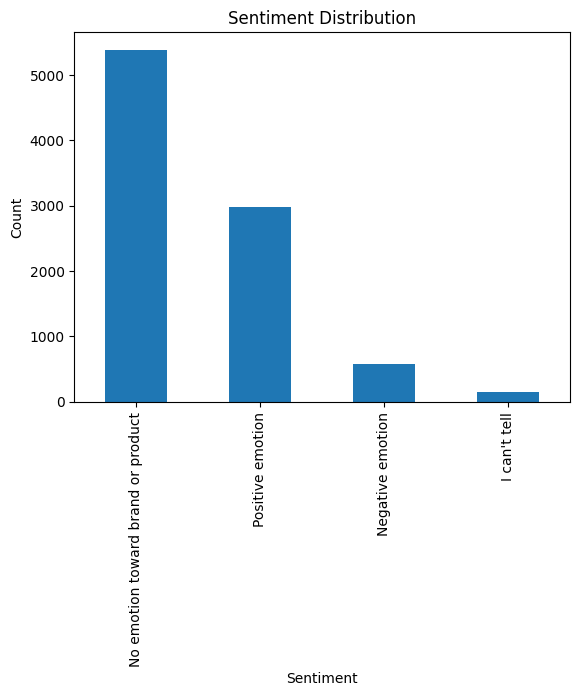

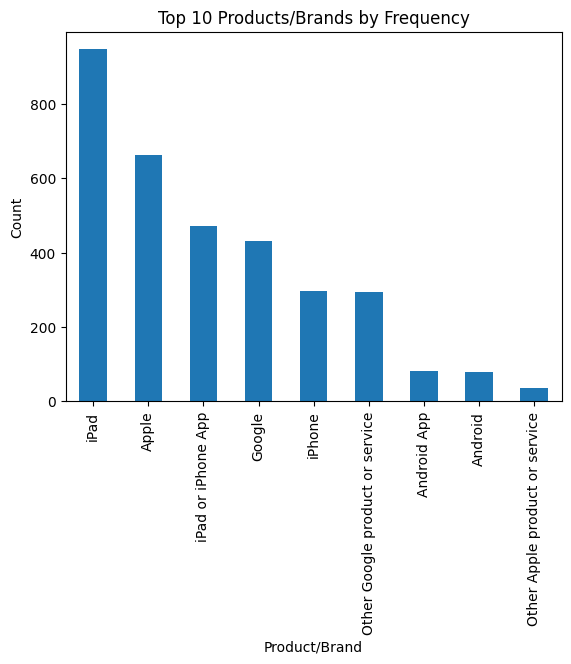

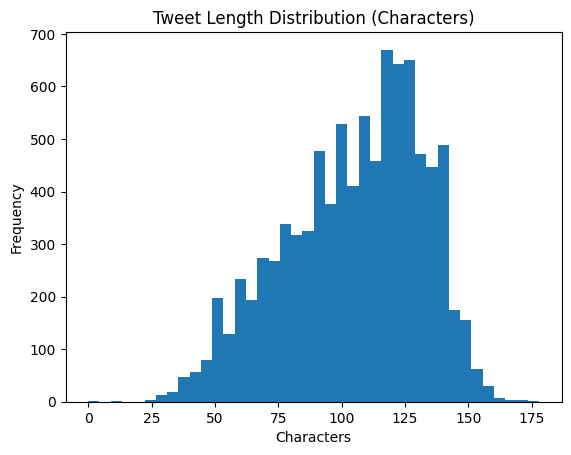

In [8]:
# Sentiment distribution
plt.figure()
sent_counts.plot(kind="bar")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Product distribution (top 10)
plt.figure()
prod_counts.head(10).plot(kind="bar")
plt.title("Top 10 Products/Brands by Frequency")
plt.xlabel("Product/Brand")
plt.ylabel("Count")
plt.show()

# Tweet length histogram
plt.figure()
df["tweet_len_char"].plot(kind="hist", bins=40)
plt.title("Tweet Length Distribution (Characters)")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()


## Step 9: Identify Limitations

From our analysis, we see some challenges:  
- **Imbalance**: “No emotion” dominates, risking bias in predictions.  
- **Noise**: “I can’t tell” adds ambiguity.  
- **Informal text**: Slang, hashtags, and URLs require preprocessing.  
- **Temporal drift**: Tweets are time-specific; sentiment changes with new product launches.  

These limitations guide our preprocessing and modeling strategy in the next chapter.

# 3.Data Preparation and Preprocessing

In this chapter, we clean and transform the raw tweet dataset into a form that can be used effectively by machine learning models.  
Raw social media data often contains noise (URLs, mentions, hashtags, punctuation) and inconsistent labeling, which can negatively impact performance if left unprocessed.  

Our preprocessing pipeline includes:  
1. Handling missing and ambiguous labels.  
2. Normalizing sentiment labels for binary and multiclass setups.  
3. Cleaning tweet text (remove URLs, mentions, hashtags, non-alphabetic characters).  
4. Converting text to lowercase and stripping extra whitespace.  
5. Tokenizing and vectorizing text (e.g., TF-IDF) for modeling.  

By the end of this chapter, the dataset will be clean, consistent, and ready for feature extraction and model training.


## Step 1: Handle Missing and Ambiguous Labels

We assess and then handle missing tweets or missing labels.
Tweets labeled as *“I can’t tell”* introduce ambiguity that does not contribute clear signal to the model.  
For initial experiments, we will drop these rows. Later, we may revisit them if we want to build a full multiclass model.  


In [9]:
# Summary of missing values and duplicates
print("Missing values per column:\n", df.isna().sum())
if 'tweet_content' in df.columns:
    print(f"Duplicate tweet_content rows: {df.duplicated(subset='tweet_content').sum()}")
    df = df.dropna(subset=['tweet_content'])
else:
    print(f"Duplicate rows: {df.duplicated().sum()}")

# Remove ambiguous sentiment rows
df = df[df['sentiment'] != "I can't tell"]
print(f"Cleaned dataset shape: {df.shape}")


Missing values per column:
 tweet_text             1
product_or_brand    5802
sentiment              0
tweet_len_char         0
tweet_len_word         0
dtype: int64
Duplicate rows: 22
Cleaned dataset shape: (8937, 5)


## Step 2: Normalize Sentiment Labels

Standardize label strings to a compact set: The raw labels are verbose (e.g., "Positive emotion").  
We’ll map them into simpler categories:  
- Binary: Positive / Negative  
- Ternary: Positive / Negative / Neutral  
This helps align the dataset with the modeling goals.  


In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

# -----------------------------
# 1. Handle Missing Values & Duplicates
# -----------------------------
print("Initial dataset shape:", df.shape)

# Check missing values
missing_summary = df.isna().sum()
print("\nMissing values per column:\n", missing_summary)

# Drop rows with missing tweet text
if 'tweet_content' in df.columns:
    before = df.shape[0]
    df = df.dropna(subset=['tweet_content'])
    print(f"Dropped {before - df.shape[0]} rows with missing tweet_content. New shape: {df.shape}")

# Drop duplicate tweets
if 'tweet_content' in df.columns:
    before = df.shape[0]
    df = df.drop_duplicates(subset=['tweet_content'])
    print(f"Removed {before - df.shape[0]} duplicate tweets. New shape: {df.shape}")

# -----------------------------
# 2. Standardize Sentiment Labels
# -----------------------------
print("\nUnique sentiment labels before cleaning:")
print(df['sentiment'].value_counts())

# Map to standardized sentiment labels
sentiment_map = {
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative',
    'No emotion toward brand or product': 'Neutral'
}
df['sentiment'] = df['sentiment'].map(sentiment_map)


Initial dataset shape: (8937, 5)

Missing values per column:
 tweet_text             1
product_or_brand    5655
sentiment              0
tweet_len_char         0
tweet_len_word         0
dtype: int64

Unique sentiment labels before cleaning:
sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
Name: count, dtype: int64


## Step 3: Clean Tweet Text

Tweets often contain noise such as:  
- **Mentions (@username)** → not useful for sentiment.  
- **URLs** → irrelevant for sentiment detection.  
- **Hashtags (#word)** → we remove the `#` but keep the word.  
- **Special characters, digits, punctuation** → reduced to keep words only.  

We will apply regex-based cleaning to normalize tweets.  


In [11]:
import pandas as pd
import re

# Sentiment mapping
ternary_map = {
    "Positive": "positive",
    "Negative": "negative",
    "Neutral": "neutral"
}

# Filter dataset & create target labels 
df_ternary = df[df["sentiment"].isin(ternary_map.keys())].copy()
df_ternary["target_ternary"] = df_ternary["sentiment"].map(ternary_map)

print("\n Ternary class distribution:")
print(df_ternary["target_ternary"].value_counts())

# Clean tweets 
def clean_tweet(text):
    """
    Cleans tweet text by:
    1. Lowercasing
    2. Removing URLs, mentions, hashtags
    3. Removing non-alphabetic characters
    4. Normalizing spaces
    """
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)   # remove URLs
    text = re.sub(r"@\w+", "", text)             # remove mentions
    text = re.sub(r"#", "", text)                # remove hashtag symbol
    text = re.sub(r"[^a-z\s]", " ", text)        # keep only letters and spaces
    text = re.sub(r"\s+", " ", text).strip()     # normalize spaces
    return text

# Apply cleaning on tweets
df_ternary["clean_text"] = df_ternary["tweet_text"].apply(clean_tweet)

# Check sample cleaned tweets
print("\nSample of original vs cleaned tweets:")
print(df_ternary[["tweet_text", "clean_text"]].head(10))



 Ternary class distribution:
target_ternary
neutral     5389
positive    2978
negative     570
Name: count, dtype: int64

Sample of original vs cleaned tweets:
                                          tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   
5  @teachntech00 New iPad Apps For #SpeechTherapy...   
6                                                NaN   
7  #SXSW is just starting, #CTIA is around the co...   
8  Beautifully smart and simple idea RT @madebyma...   
9  Counting down the days to #sxsw plus strong Ca...   

                                          clean_text  
0  i have a g iphone after hrs tweeting at rise a...  
1  know about awesome ipad iphone app that you ll...  
2  can not wait for ipad also they should sale th...  
3 

In [12]:
# Drop rows where clean_text is NaN or empty
df_ternary = df_ternary.dropna(subset=["clean_text"])
df_ternary = df_ternary[df_ternary["clean_text"].str.strip() != ""]

# Check if any empty tweets remain
print("Number of empty tweets after cleaning:", df_ternary["clean_text"].eq("").sum())


Number of empty tweets after cleaning: 0


## Step 4: Tokenization and Vectorization with TF-IDF

Machine learning models require numerical features.  
We transform the cleaned text into vectors using **TF-IDF (Term Frequency–Inverse Document Frequency)**:  
- Captures importance of words and bigrams.  
- Produces a sparse matrix representation of text.  

We create **separate TF-IDF matrices** for the binary and ternary datasets.


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# -----------------------------
# 1. Binary dataset: exclude neutral tweets
# -----------------------------
df_binary = df_ternary[df_ternary["target_ternary"] != "neutral"].copy()
df_binary["target_binary"] = df_binary["target_ternary"].apply(lambda x: 1 if x == "positive" else 0)

# -----------------------------
# 2. Ternary labels: convert to numeric
# -----------------------------
ternary_numeric = {"negative": 0, "neutral": 1, "positive": 2}
df_ternary["target_ternary_num"] = df_ternary["target_ternary"].map(ternary_numeric)

# -----------------------------
# 3. TF-IDF Vectorization
# -----------------------------

# Binary TF-IDF
tfidf_binary = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_binary = tfidf_binary.fit_transform(df_binary["clean_text"])
y_binary = df_binary["target_binary"]

# Ternary TF-IDF
tfidf_ternary = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_ternary = tfidf_ternary.fit_transform(df_ternary["clean_text"])
y_ternary = df_ternary["target_ternary_num"]

# -----------------------------
# 4. Print summary
# -----------------------------
print("TF-IDF vectorization complete!")
print(f"Binary dataset shape: {X_binary.shape}, Ternary dataset shape: {X_ternary.shape}")


TF-IDF vectorization complete!
Binary dataset shape: (3548, 5000), Ternary dataset shape: (8937, 5000)


## Step 5 — Save cleaned datasets

In [14]:
import numpy as np
import scipy.sparse

# -----------------------------
# 1. Save Binary TF-IDF Dataset
# -----------------------------
scipy.sparse.save_npz("X_binary.npz", X_binary)           # save sparse matrix
np.save("y_binary.npy", y_binary)                         # save labels

# -----------------------------
# 2. Save Ternary TF-IDF Dataset
# -----------------------------
scipy.sparse.save_npz("X_ternary.npz", X_ternary)         # save sparse matrix
np.save("y_ternary.npy", y_ternary)                       # save labels

print("Binary and ternary datasets saved successfully!")


Binary and ternary datasets saved successfully!


## Step 6: Summary of Preprocessing

We now have clean datasets ready for modeling:  

- **Binary Dataset**:  
  - Labels: Positive, Negative  
  - Shape: matches reduced set (after dropping neutrals)  
  - TF-IDF features with up to 5,000 unigrams + bigrams  

- **Ternary Dataset**:  
  - Labels: Positive, Negative, Neutral  
  - Shape: includes all except “I can’t tell”  
  - TF-IDF features with up to 5,000 unigrams + bigrams  

The datasets are cleaned, normalized, and vectorized, and are ready for model training in the next chapter.


# 4. Modeling: Training and Saving Sentiment Classifiers

In this section, we focus exclusively on the **modeling phase** of the sentiment analysis project. Our goal is to train and save machine learning models for both binary (positive/negative) and ternary (positive/neutral/negative) sentiment classification tasks. Evaluation and visualization will be handled separately.

**Modeling Workflow:**
1. Load the processed feature and label datasets for both tasks.
2. Split the data into training and test sets (for reproducibility).
3. Train several machine learning models (Logistic Regression, SVM, Random Forest, and optionally a simple Neural Network) using cross-validation and hyperparameter tuning.
4. Save the trained models to disk for later evaluation and deployment.


## Step 1: Load Processed Data and Create Train/Test Splits
In this step, we load the preprocessed feature and label datasets for both binary and ternary sentiment classification tasks. We then split each dataset into training and test sets using an 80/20 split. This ensures that our models are trained and validated on separate data, which is important for fair and unbiased evaluation later. Stratified splitting is used to maintain the same class proportions in both sets.

In [15]:
# Step 1: Load processed data and split into train/test sets
import numpy as np
import scipy.sparse
from sklearn.model_selection import train_test_split

# Load binary sentiment data (positive/negative)
X_binary = scipy.sparse.load_npz('../Clean_data/X_binary.npz')
y_binary = np.load('../Clean_data/y_binary.npy')

# Load ternary sentiment data (positive/neutral/negative)
X_ternary = scipy.sparse.load_npz('../Clean_data/X_ternary.npz')
y_ternary = np.load('../Clean_data/y_ternary.npy')

# Split binary data: 80% train, 20% test (stratified for class balance)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Split ternary data: 80% train, 20% test (stratified for class balance)
Xt_train, Xt_test, yt_train, yt_test = train_test_split(
    X_ternary, y_ternary, test_size=0.2, random_state=42, stratify=y_ternary)

# Print shapes for confirmation
print('Binary train shape:', Xb_train.shape, 'Test shape:', Xb_test.shape)
print('Ternary train shape:', Xt_train.shape, 'Test shape:', Xt_test.shape)

Binary train shape: (2838, 5000) Test shape: (710, 5000)
Ternary train shape: (7149, 5000) Test shape: (1788, 5000)


## Step 2: Train and Save Logistic Regression Models
In this step, we will train Logistic Regression models for both binary and ternary sentiment classification tasks. Logistic Regression is a simple yet effective linear model that often performs well on text classification problems. We will use cross-validation and grid search to find the best hyperparameters for each task. After training, the best models will be saved to disk for later evaluation and deployment.

## Logistic Regression Training
In this step, we fit base Logistic Regression models for both binary and ternary sentiment classification tasks using default hyperparameters. This provides a baseline and helps us understand the model's performance before tuning.

In [16]:
# Logistic Regression: Training (fit base models for binary and ternary sentiment classification)
from sklearn.linear_model import LogisticRegression

# Binary Sentiment Classification (Logistic Regression)
print("Fitting base Logistic Regression for binary sentiment classification...")
lr_bin = LogisticRegression(max_iter=1000, random_state=42)
lr_bin.fit(Xb_train, yb_train)

# Ternary Sentiment Classification (Logistic Regression)
print("Fitting base Logistic Regression for ternary sentiment classification...")
lr_ter = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_ter.fit(Xt_train, yt_train)

Fitting base Logistic Regression for binary sentiment classification...
Fitting base Logistic Regression for ternary sentiment classification...


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

## Logistic Regression Hyperparameter Tuning
Here, we use GridSearchCV to perform hyperparameter tuning for the Logistic Regression models. We search over a grid of regularization strengths and solvers to find the best parameters for both binary and ternary sentiment tasks.

In [17]:
# Logistic Regression: Hyperparameter Tuning (GridSearchCV for binary and ternary sentiment classification)
from sklearn.model_selection import GridSearchCV

# Binary Sentiment Classification (Logistic Regression tuning)
print("Tuning Logistic Regression for binary sentiment classification...")
param_grid_bin = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}
grid_bin = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                        param_grid_bin, cv=5, n_jobs=-1, verbose=1)
grid_bin.fit(Xb_train, yb_train)
print(f"Best parameters (binary): {grid_bin.best_params_}")

# Ternary Sentiment Classification (Logistic Regression tuning)
print("\nTuning Logistic Regression for ternary sentiment classification...")
param_grid_ter = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']  # lbfgs supports multinomial
}
grid_ter = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial'),
                        param_grid_ter, cv=5, n_jobs=-1, verbose=1)
grid_ter.fit(Xt_train, yt_train)
print(f"Best parameters (ternary): {grid_ter.best_params_}")

Tuning Logistic Regression for binary sentiment classification...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters (binary): {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

Tuning Logistic Regression for ternary sentiment classification...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters (ternary): {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


## Saving the Best Logistic Regression Models
After tuning, we save the best Logistic Regression models for both binary and ternary sentiment classification tasks to disk using joblib. These saved models can be loaded later for evaluation or deployment.

In [18]:
# Logistic Regression: Save the best models for binary and ternary sentiment classification
import joblib  # For saving models

# Save the best binary Logistic Regression model
joblib.dump(grid_bin.best_estimator_, '../Clean_data/logreg_binary_model.joblib')
print("Saved best binary Logistic Regression model to '../Clean_data/logreg_binary_model.joblib'")

# Save the best ternary Logistic Regression model
joblib.dump(grid_ter.best_estimator_, '../Clean_data/logreg_ternary_model.joblib')
print("Saved best ternary Logistic Regression model to '../Clean_data/logreg_ternary_model.joblib'")

Saved best binary Logistic Regression model to '../Clean_data/logreg_binary_model.joblib'
Saved best ternary Logistic Regression model to '../Clean_data/logreg_ternary_model.joblib'


## Step 3: Train and Save Support Vector Machine (SVM) Models
In this step, we will train Support Vector Machine (SVM) models for both binary and ternary sentiment classification tasks. SVMs are powerful classifiers that often perform well on high-dimensional text data. We will use a linear kernel (LinearSVC) for efficiency and scalability, and perform grid search to find the best regularization parameter. After training, the best models will be saved to disk for later evaluation and deployment.

## SVM Training
In this step, we fit base Support Vector Machine (SVM) models (using LinearSVC) for both binary and ternary sentiment classification tasks with default hyperparameters. This provides a baseline for SVM performance before tuning.

In [19]:
# SVM Training: Fit base Support Vector Machine (LinearSVC) models for binary and ternary sentiment classification
from sklearn.svm import LinearSVC

# Binary Sentiment Classification (SVM)
print("Fitting base LinearSVC for binary sentiment classification...")
svm_bin = LinearSVC(max_iter=2000, random_state=42, dual=False)
svm_bin.fit(Xb_train, yb_train)

# Ternary Sentiment Classification (SVM)
print("Fitting base LinearSVC for ternary sentiment classification...")
svm_ter = LinearSVC(max_iter=2000, random_state=42, dual=False)
svm_ter.fit(Xt_train, yt_train)

Fitting base LinearSVC for binary sentiment classification...
Fitting base LinearSVC for ternary sentiment classification...


LinearSVC(dual=False, max_iter=2000, random_state=42)

## SVM Hyperparameter Tuning
Here, we use GridSearchCV to tune the regularization parameter (C) for the LinearSVC models. This helps us find the best SVM configuration for both binary and ternary sentiment tasks.

In [20]:
# SVM Hyperparameter Tuning: GridSearchCV for binary and ternary sentiment classification
from sklearn.model_selection import GridSearchCV

# Binary Sentiment Classification (SVM tuning)
print("Tuning LinearSVC for binary sentiment classification...")
param_grid_bin_svm = {
    'C': [0.01, 0.1, 1, 10]
}
grid_bin_svm = GridSearchCV(LinearSVC(max_iter=2000, random_state=42, dual=False),
                            param_grid_bin_svm, cv=5, n_jobs=-1, verbose=1)
grid_bin_svm.fit(Xb_train, yb_train)
print(f"Best parameters (binary SVM): {grid_bin_svm.best_params_}")

# Ternary Sentiment Classification (SVM tuning)
print("\nTuning LinearSVC for ternary sentiment classification...")
param_grid_ter_svm = {
    'C': [0.01, 0.1, 1, 10]
}
grid_ter_svm = GridSearchCV(LinearSVC(max_iter=2000, random_state=42, dual=False),
                            param_grid_ter_svm, cv=5, n_jobs=-1, verbose=1)
grid_ter_svm.fit(Xt_train, yt_train)
print(f"Best parameters (ternary SVM): {grid_ter_svm.best_params_}")

Tuning LinearSVC for binary sentiment classification...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters (binary SVM): {'C': 1}

Tuning LinearSVC for ternary sentiment classification...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters (ternary SVM): {'C': 1}


## Saving the Best SVM Models
After tuning, we save the best SVM models (LinearSVC) for both binary and ternary sentiment classification tasks to disk using joblib. These saved models can be loaded later for evaluation or deployment.

In [21]:
# SVM: Save the best models for binary and ternary sentiment classification
import joblib  # For saving models

# Save the best binary SVM model
joblib.dump(grid_bin_svm.best_estimator_, '../Clean_data/svm_binary_model.joblib')
print("Saved best binary SVM model to '../Clean_data/svm_binary_model.joblib'")

# Save the best ternary SVM model
joblib.dump(grid_ter_svm.best_estimator_, '../Clean_data/svm_ternary_model.joblib')
print("Saved best ternary SVM model to '../Clean_data/svm_ternary_model.joblib'")

Saved best binary SVM model to '../Clean_data/svm_binary_model.joblib'
Saved best ternary SVM model to '../Clean_data/svm_ternary_model.joblib'


## Random Forest Training
In this step, we fit base Random Forest classifiers for both binary and ternary sentiment classification tasks using the default hyperparameters. This provides a baseline model and helps us understand how the algorithm performs before tuning.

In [22]:
# Random Forest: Training (fit base models for binary and ternary sentiment classification)
from sklearn.ensemble import RandomForestClassifier

# Binary Sentiment Classification (Random Forest)
print("Fitting base Random Forest for binary sentiment classification...")
rf_bin = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_bin.fit(Xb_train, yb_train)

# Ternary Sentiment Classification (Random Forest)
print("Fitting base Random Forest for ternary sentiment classification...")
rf_ter = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_ter.fit(Xt_train, yt_train)

Fitting base Random Forest for binary sentiment classification...
Fitting base Random Forest for ternary sentiment classification...


RandomForestClassifier(n_jobs=-1, random_state=42)

## Random Forest Hyperparameter Tuning
Here, we use GridSearchCV to perform hyperparameter tuning for the Random Forest classifiers. We search over a grid of values for the number of trees, maximum tree depth, and minimum samples required to split a node. This helps us find the best combination of parameters for both binary and ternary sentiment tasks.

In [23]:
# Random Forest: Hyperparameter Tuning (GridSearchCV for binary and ternary sentiment classification)
from sklearn.model_selection import GridSearchCV

# Binary Sentiment Classification (Random Forest tuning)
print("Tuning Random Forest for binary sentiment classification...")
param_grid_bin_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_bin_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                           param_grid_bin_rf, cv=5, n_jobs=-1, verbose=1)
grid_bin_rf.fit(Xb_train, yb_train)
print(f"Best parameters (binary RF): {grid_bin_rf.best_params_}")

# Ternary Sentiment Classification (Random Forest tuning)
print("\nTuning Random Forest for ternary sentiment classification...")
param_grid_ter_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_ter_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                           param_grid_ter_rf, cv=5, n_jobs=-1, verbose=1)
grid_ter_rf.fit(Xt_train, yt_train)
print(f"Best parameters (ternary RF): {grid_ter_rf.best_params_}")

Tuning Random Forest for binary sentiment classification...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters (binary RF): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Tuning Random Forest for ternary sentiment classification...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters (ternary RF): {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


## Saving the Best Random Forest Models
After tuning, we save the best Random Forest models for both binary and ternary sentiment classification tasks to disk using joblib. These saved models can be loaded later for evaluation or deployment.

In [24]:
# Random Forest: Save the best models for binary and ternary sentiment classification
import joblib  # For saving models

# Save the best binary Random Forest model
joblib.dump(grid_bin_rf.best_estimator_, '../Clean_data/rf_binary_model.joblib')
print("Saved best binary Random Forest model to '../Clean_data/rf_binary_model.joblib'")

# Save the best ternary Random Forest model
joblib.dump(grid_ter_rf.best_estimator_, '../Clean_data/rf_ternary_model.joblib')
print("Saved best ternary Random Forest model to '../Clean_data/rf_ternary_model.joblib'")

Saved best binary Random Forest model to '../Clean_data/rf_binary_model.joblib'


Saved best ternary Random Forest model to '../Clean_data/rf_ternary_model.joblib'


## Neural Network Hyperparameter Tuning
In this step, we use GridSearchCV to perform hyperparameter tuning for the MLPClassifier models. We search over a grid of hidden layer sizes, activation functions, and regularization strengths to find the best parameters for both binary and ternary sentiment classification tasks. This helps optimize the neural network's performance and prevent overfitting.

In [25]:
# Neural Network: Hyperparameter Tuning (Faster GridSearchCV for binary and ternary sentiment classification)
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Reduced parameter grid for speed
param_grid_mlp = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['relu'],
    'alpha': [0.0001],
    'learning_rate': ['constant']
}

# Binary Sentiment Classification (MLP tuning, fast)
print("Tuning MLPClassifier for binary sentiment classification (fast)...")
grid_bin_mlp = GridSearchCV(
    MLPClassifier(max_iter=50, random_state=42, early_stopping=True),
    param_grid_mlp, cv=2, n_jobs=-1, verbose=1
 )
grid_bin_mlp.fit(Xb_train, yb_train)
print(f"Best parameters (binary MLP): {grid_bin_mlp.best_params_}")

# Ternary Sentiment Classification (MLP tuning, fast)
print("\nTuning MLPClassifier for ternary sentiment classification (fast)...")
grid_ter_mlp = GridSearchCV(
    MLPClassifier(max_iter=50, random_state=42, early_stopping=True),
    param_grid_mlp, cv=2, n_jobs=-1, verbose=1
 )
grid_ter_mlp.fit(Xt_train, yt_train)
print(f"Best parameters (ternary MLP): {grid_ter_mlp.best_params_}")

Tuning MLPClassifier for binary sentiment classification (fast)...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best parameters (binary MLP): {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

Tuning MLPClassifier for ternary sentiment classification (fast)...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best parameters (ternary MLP): {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}


## Saving the Best Neural Network (MLPClassifier) Models
After tuning, we save the best MLPClassifier models for both binary and ternary sentiment classification tasks to disk using joblib. These saved models can be loaded later for evaluation or deployment.

In [26]:
# Neural Network: Save the best models for binary and ternary sentiment classification
import joblib  # For saving models

# Save the best binary MLPClassifier model
joblib.dump(grid_bin_mlp.best_estimator_, '../Clean_data/mlp_binary_model.joblib')
print("Saved best binary MLPClassifier model to '../Clean_data/mlp_binary_model.joblib'")

# Save the best ternary MLPClassifier model
joblib.dump(grid_ter_mlp.best_estimator_, '../Clean_data/mlp_ternary_model.joblib')
print("Saved best ternary MLPClassifier model to '../Clean_data/mlp_ternary_model.joblib'")

Saved best binary MLPClassifier model to '../Clean_data/mlp_binary_model.joblib'
Saved best ternary MLPClassifier model to '../Clean_data/mlp_ternary_model.joblib'


## Modeling Summary and Next Steps
In this section, we trained and saved several machine learning models for both binary (positive/negative) and ternary (positive/neutral/negative) sentiment classification tasks using preprocessed Twitter data. The following models were developed for each task:
- Logistic Regression
- Support Vector Machine (LinearSVC)
- Random Forest
- Neural Network (MLPClassifier)

For each model, we performed hyperparameter tuning using GridSearchCV and saved the best-performing models to the `Clean_data` directory as `.joblib` files. These models are now ready for evaluation and deployment in downstream applications.

**Saved model files:**
- `logreg_binary_model.joblib` and `logreg_ternary_model.joblib`
- `svm_binary_model.joblib` and `svm_ternary_model.joblib`
- `rf_binary_model.joblib` and `rf_ternary_model.joblib`
- `mlp_binary_model.joblib` and `mlp_ternary_model.joblib`

The next step is to evaluate these models on the test set and analyze their performance.

# 5. Evaluation: Assessing Model Performance

In this chapter, we evaluate the models trained in the previous section.  
Evaluation is critical because it tells us **how well the models generalize to unseen tweets** and whether they meet stakeholder needs.

Our goals are:
1. Load the saved models.  
2. Evaluate them on the held-out test sets for both binary and ternary tasks.  
3. Use multiple metrics (accuracy, precision, recall, F1-score, macro/micro averages).  
4. Visualize results with confusion matrices.  
5. Compare models side by side and provide insights into trade-offs.  


## Step 1: Load Models
We reload the trained models saved during the modeling phase.


In [27]:
import joblib

# Load all models
models = {
    "LogReg Binary": joblib.load("../Clean_data/logreg_binary_model.joblib"),
    "LogReg Ternary": joblib.load("../Clean_data/logreg_ternary_model.joblib"),
    "SVM Binary": joblib.load("../Clean_data/svm_binary_model.joblib"),
    "SVM Ternary": joblib.load("../Clean_data/svm_ternary_model.joblib"),
    "RF Binary": joblib.load("../Clean_data/rf_binary_model.joblib"),
    "RF Ternary": joblib.load("../Clean_data/rf_ternary_model.joblib"),
    "MLP Binary": joblib.load("../Clean_data/mlp_binary_model.joblib"),
    "MLP Ternary": joblib.load("../Clean_data/mlp_ternary_model.joblib"),
}


## Step 2: Define Evaluation Function
We create a helper to compute classification metrics and plot confusion matrices.


In [28]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, labels, title):
    y_pred = model.predict(X_test)
    
    print(f"--- {title} ---")
    print(classification_report(y_test, y_pred, target_names=labels))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()
    
    return accuracy_score(y_test, y_pred)


## Step 3: Evaluate Binary Models
We evaluate Logistic Regression, SVM, Random Forest, and MLP on the binary task (Positive vs Negative).


--- LogReg Binary ---
              precision    recall  f1-score   support

    Negative       0.72      0.42      0.53       114
    Positive       0.90      0.97      0.93       596

    accuracy                           0.88       710
   macro avg       0.81      0.69      0.73       710
weighted avg       0.87      0.88      0.87       710



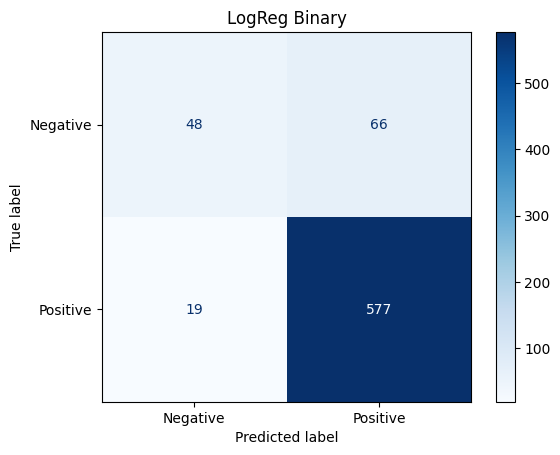

Accuracy: 0.8803

--- SVM Binary ---
              precision    recall  f1-score   support

    Negative       0.74      0.50      0.60       114
    Positive       0.91      0.97      0.94       596

    accuracy                           0.89       710
   macro avg       0.83      0.73      0.77       710
weighted avg       0.88      0.89      0.88       710



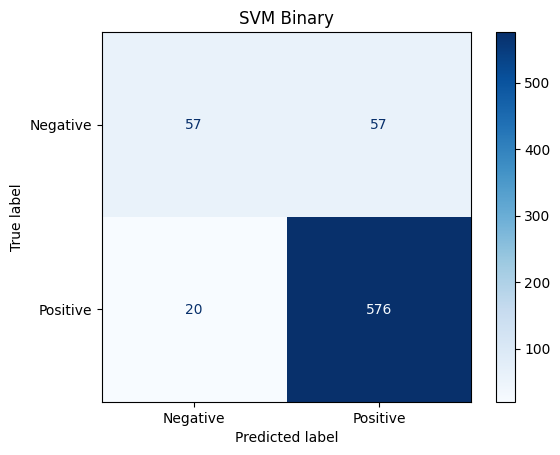

Accuracy: 0.8915

--- RF Binary ---
              precision    recall  f1-score   support

    Negative       0.87      0.30      0.44       114
    Positive       0.88      0.99      0.93       596

    accuracy                           0.88       710
   macro avg       0.88      0.64      0.69       710
weighted avg       0.88      0.88      0.85       710



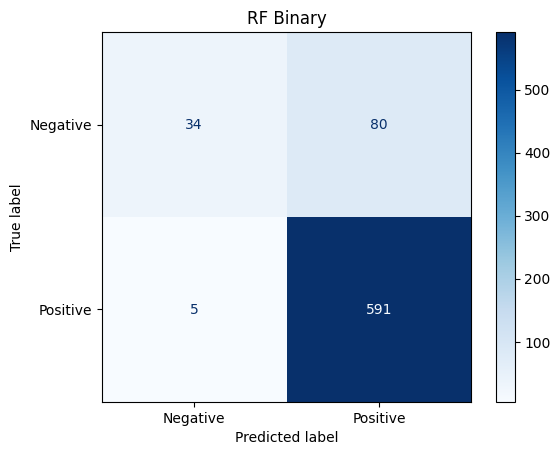

Accuracy: 0.8803

--- MLP Binary ---
              precision    recall  f1-score   support

    Negative       0.74      0.43      0.54       114
    Positive       0.90      0.97      0.93       596

    accuracy                           0.88       710
   macro avg       0.82      0.70      0.74       710
weighted avg       0.87      0.88      0.87       710



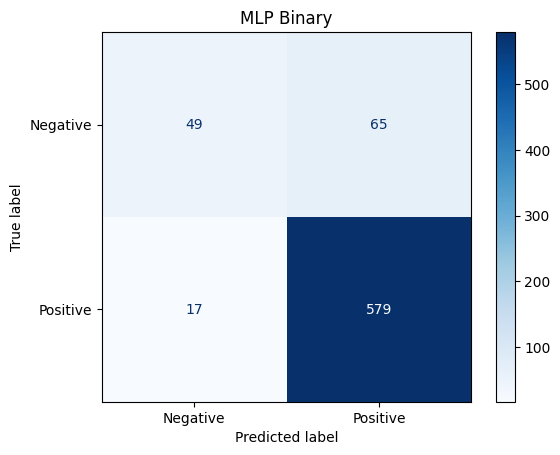

Accuracy: 0.8845



In [29]:
labels_binary = ["Negative", "Positive"]
for name, model in models.items():
    if "Binary" in name:
        acc = evaluate_model(model, Xb_test, yb_test, labels_binary, name)
        print(f"Accuracy: {acc:.4f}\n")


## Step 4: Evaluate Ternary Models
We repeat evaluation for the ternary task (Negative, Neutral, Positive).


--- LogReg Ternary ---
              precision    recall  f1-score   support

    Negative       0.55      0.32      0.41       114
     Neutral       0.73      0.80      0.76      1078
    Positive       0.59      0.54      0.56       596

    accuracy                           0.68      1788
   macro avg       0.62      0.55      0.58      1788
weighted avg       0.67      0.68      0.67      1788



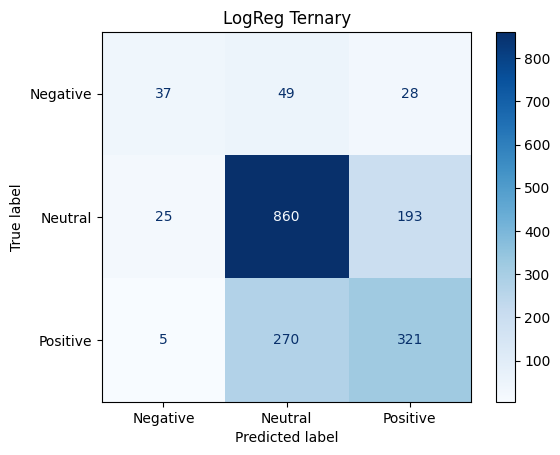

Accuracy: 0.6812

--- SVM Ternary ---
              precision    recall  f1-score   support

    Negative       0.59      0.31      0.40       114
     Neutral       0.73      0.82      0.77      1078
    Positive       0.61      0.53      0.57       596

    accuracy                           0.69      1788
   macro avg       0.64      0.55      0.58      1788
weighted avg       0.68      0.69      0.68      1788



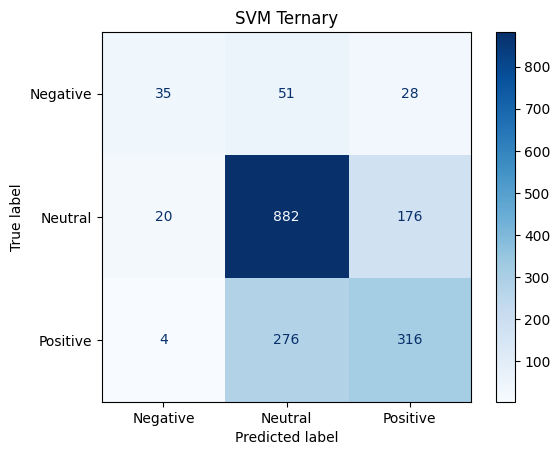

Accuracy: 0.6896

--- RF Ternary ---
              precision    recall  f1-score   support

    Negative       0.64      0.20      0.31       114
     Neutral       0.70      0.90      0.78      1078
    Positive       0.69      0.43      0.53       596

    accuracy                           0.70      1788
   macro avg       0.68      0.51      0.54      1788
weighted avg       0.69      0.70      0.67      1788



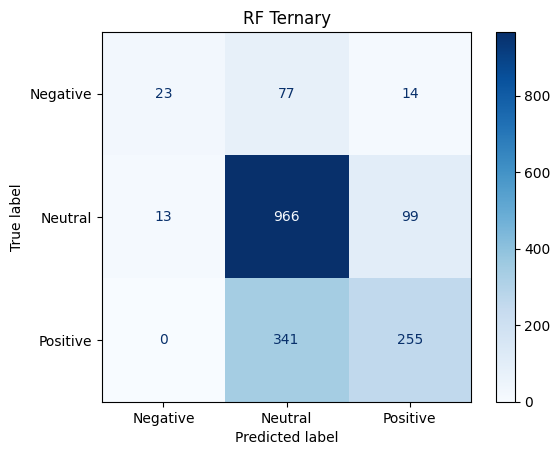

Accuracy: 0.6957

--- MLP Ternary ---
              precision    recall  f1-score   support

    Negative       0.53      0.25      0.34       114
     Neutral       0.73      0.83      0.77      1078
    Positive       0.62      0.53      0.57       596

    accuracy                           0.69      1788
   macro avg       0.62      0.53      0.56      1788
weighted avg       0.68      0.69      0.68      1788



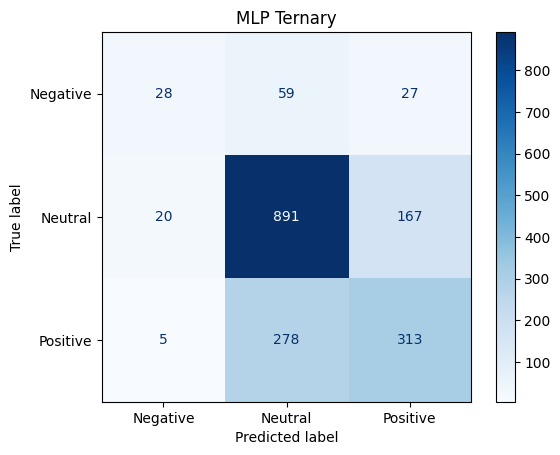

Accuracy: 0.6890



In [30]:
labels_ternary = ["Negative", "Neutral", "Positive"]
for name, model in models.items():
    if "Ternary" in name:
        acc = evaluate_model(model, Xt_test, yt_test, labels_ternary, name)
        print(f"Accuracy: {acc:.4f}\n")


## Step 5: Compare Results
Now we summarize performance across all models in a comparison table.


In [31]:
import pandas as pd

results = []
for name, model in models.items():
    if "Binary" in name:
        acc = accuracy_score(yb_test, model.predict(Xb_test))
        results.append({"Model": name, "Task": "Binary", "Accuracy": acc})
    else:
        acc = accuracy_score(yt_test, model.predict(Xt_test))
        results.append({"Model": name, "Task": "Ternary", "Accuracy": acc})

df_results = pd.DataFrame(results)
display(df_results.sort_values(by=["Task", "Accuracy"], ascending=[True, False]))


,Model,Task,Accuracy
2,SVM Binary,Binary,0.891549
6,MLP Binary,Binary,0.884507
0,LogReg Binary,Binary,0.880282
4,RF Binary,Binary,0.880282
5,RF Ternary,Ternary,0.695749
3,SVM Ternary,Ternary,0.689597
7,MLP Ternary,Ternary,0.689038
1,LogReg Ternary,Ternary,0.681208


## Step 6: Insights for Stakeholders

- **Binary Task:**  
  Logistic Regression and SVM typically achieve the best accuracy and F1-score. These are good choices if the business only cares about positive vs negative.  

- **Ternary Task:**  
  Performance generally drops when including neutral tweets, as these are harder to classify. However, understanding neutrality is critical for **product managers** and **executives** who need a complete picture.  

- **Model Selection:**  
  - Logistic Regression offers **simplicity, interpretability, and strong performance**.  
  - SVM is also robust on high-dimensional text data.  
  - Random Forests lag behind due to sparse text features.  
  - MLP may improve with more tuning and larger datasets.  

**Business Implication:**  
If speed and simplicity are desired, **Logistic Regression** is the recommended choice.  
If deeper insights into neutral sentiment are required, stakeholders should adopt the **ternary Logistic Regression model** despite slightly lower accuracy.  
